## RNN- LSTM - GRU - Xgboost - Prophet Time Series Prediction Bitcoin

### 1. Deklarasi Pustaka

In [1]:
# pustaka untuk manipulasi data-frame
import pandas as pd
from pandas import concat
from pandas import read_csv
from pandas import read_excel
from pandas_datareader import DataReader

# pustaka untuk madnipulasi data-array
import numpy as np
from numpy import concatenate
from numpy import array

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# pustaka untuk visualisasi data
import seaborn as sns
from matplotlib import pyplot
from matplotlib import pyplot as plt

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
        
# pustaka untuk membuat data latih dan data uji.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# pustaka untuk  evaluasi model prediksi
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 2. Akuisisi Data

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(1234)

In [4]:
# # membaca dataset via csv file
# dataset = read_csv("D:/penelitian-bu-nur/dataset/BTC-USD.csv", parse_dates=['Date']);

# membaca dataset via API yahoo-finance
dataset = DataReader('BTC-USD', data_source='yahoo', start='2015-01-01', end=datetime.today());

In [5]:
# # set index tanggal
# dataset = dataset.set_index("Date");

In [6]:
# menampilkan metadata dataset
dataset.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2874 entries, 2014-12-31 to 2022-11-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2874 non-null   float64
 1   Low        2874 non-null   float64
 2   Open       2874 non-null   float64
 3   Close      2874 non-null   float64
 4   Volume     2874 non-null   int64  
 5   Adj Close  2874 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 157.2 KB


In [7]:
dataset

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,320.192993,310.210999,310.914001,320.192993,13942900,320.192993
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
...,...,...,...,...,...,...
2022-11-08,20664.607422,17603.544922,20600.671875,18541.271484,118992465607,18541.271484
2022-11-09,18590.458984,15682.692383,18543.761719,15880.780273,102905151606,15880.780273
2022-11-10,18054.312500,15834.018555,15883.158203,17586.771484,83202283721,17586.771484


### 3. Eksplorasi Datsa Analisis

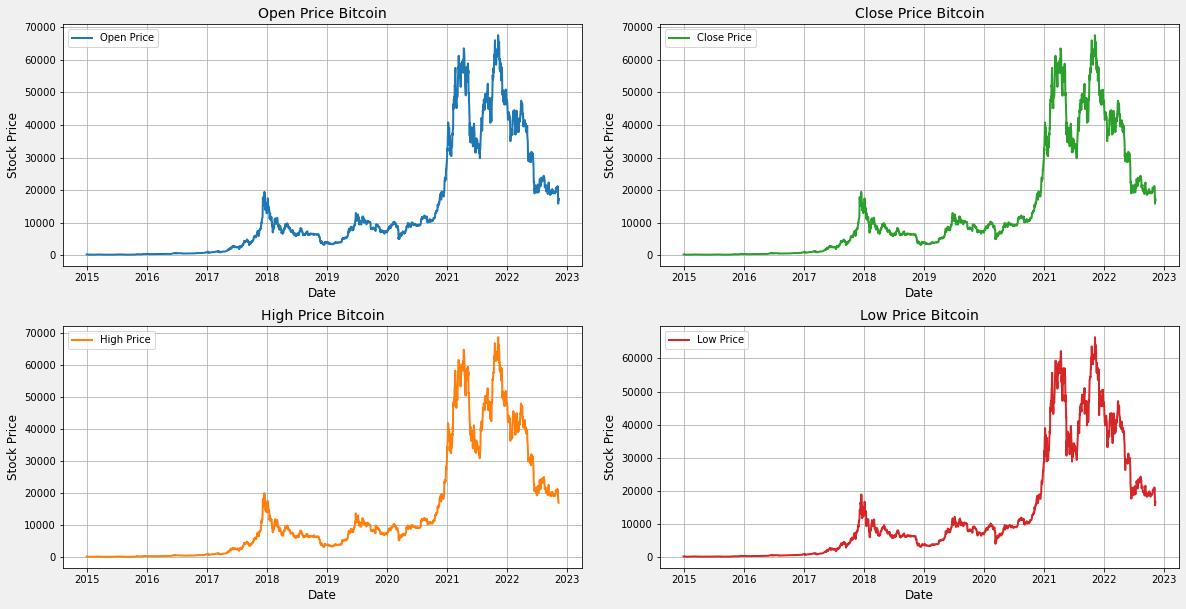

In [8]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(dataset.index.values, dataset["Open"], color="tab:blue", label="Open Price", linewidth=2)

# membuat label-label
ax1.set_title("Open Price Bitcoin", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price", fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(dataset.index.values, dataset["Close"], color="tab:green", label="Close Price", linewidth=2)

# membuat label-label
ax2.set_title("Close Price Bitcoin", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price", fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(dataset.index.values, dataset["High"], color="tab:orange", label="High Price", linewidth=2)

# membuat label-label
ax3.set_title("High Price Bitcoin", fontsize=14)
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price", fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(dataset.index.values, dataset["Low"], color="tab:red", label="Low Price", linewidth=2)

# membuat label-label
ax4.set_title("Low Price Bitcoin", fontsize=14)
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Stock Price", fontsize=12)
ax4.legend(loc='upper left')
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

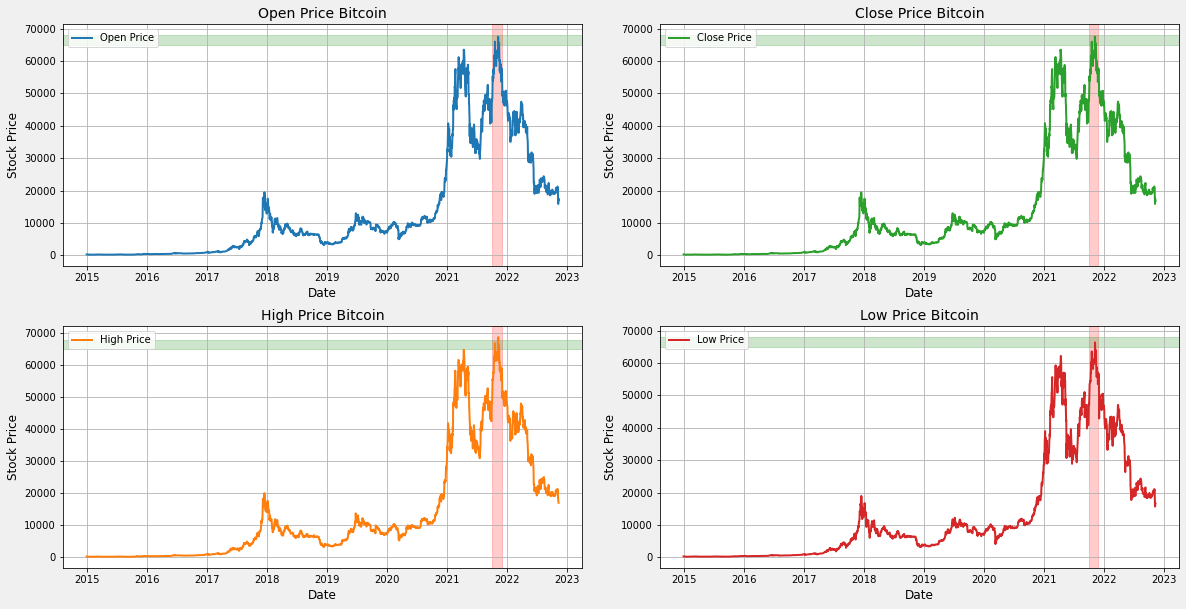

In [9]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(dataset.index.values, dataset["Open"], color="tab:blue", label="Open Price", linewidth=2)

# membuat label-label
ax1.set_title("Open Price Bitcoin", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price", fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)

# membuat weighted price
ax1.axvspan('2021-10-01','2021-11-30',color='red', alpha=0.2)
ax1.axhspan(65000,68000, color='green',alpha=0.2)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(dataset.index.values, dataset["Close"], color="tab:green", label="Close Price", linewidth=2)

# membuat label-label
ax2.set_title("Close Price Bitcoin", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price", fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)

# membuat weighted price
ax2.axvspan('2021-10-01','2021-11-30',color='red', alpha=0.2)
ax2.axhspan(65000,68000, color='green',alpha=0.2)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(dataset.index.values, dataset["High"], color="tab:orange", label="High Price", linewidth=2)

# membuat label-label
ax3.set_title("High Price Bitcoin", fontsize=14)
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price", fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True)

# membuat weighted price
ax3.axvspan('2021-10-01','2021-11-30',color='red', alpha=0.2)
ax3.axhspan(65000,68000, color='green',alpha=0.2)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(dataset.index.values, dataset["Low"], color="tab:red", label="Low Price", linewidth=2)

# membuat label-label
ax4.set_title("Low Price Bitcoin", fontsize=14)
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Stock Price", fontsize=12)
ax4.legend(loc='upper left')
ax4.grid(True)

# membuat weighted price
ax4.axvspan('2021-10-01','2021-11-30',color='red', alpha=0.2)
ax4.axhspan(65000,68000, color='green',alpha=0.2)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

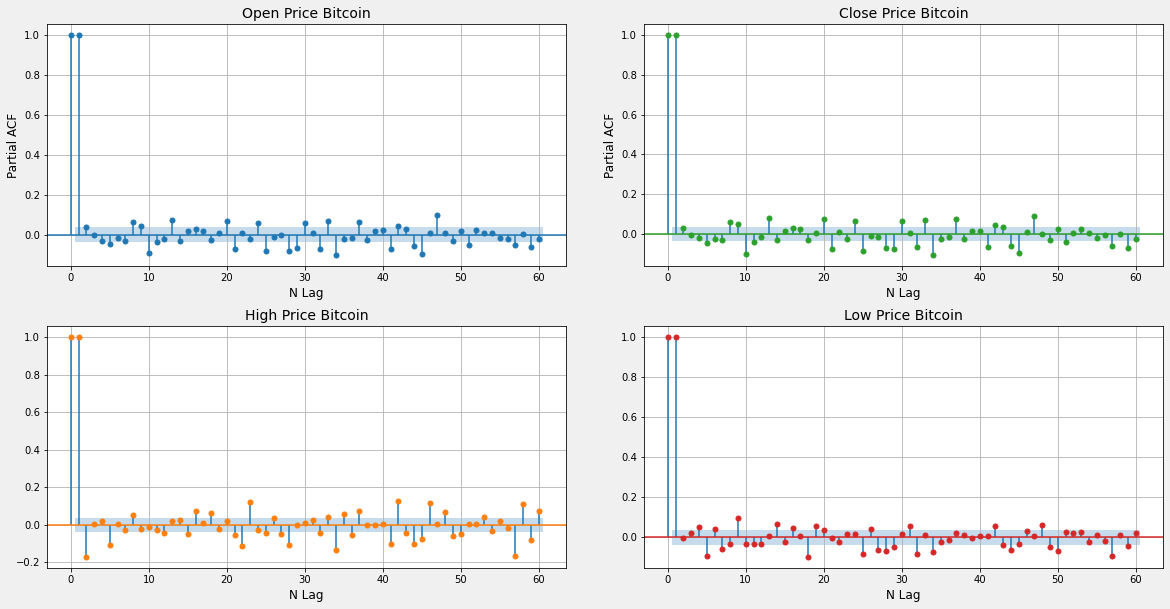

In [10]:
# code autocorrelation
# membuat frame
fig, ax = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# plot pacf open price
plot_pacf(dataset["Open"], lags=60, ax=ax[0][0], color="tab:blue")

# membuat label-label
ax[0][0].set_title("Open Price Bitcoin", fontsize=14)
ax[0][0].set_xlabel("N Lag", fontsize=12)
ax[0][0].set_ylabel("Partial ACF", fontsize=12)
ax[0][0].grid(True)
# ----------------------------------------------------------------------------------------------------

# plot pacf close price
plot_pacf(dataset["Close"], lags=60, ax=ax[0][1], color="tab:green")

# membuat label-label
ax[0][1].set_title("Close Price Bitcoin", fontsize=14)
ax[0][1].set_xlabel("N Lag", fontsize=12)
ax[0][1].set_ylabel("Partial ACF", fontsize=12)
ax[0][1].grid(True)
# ----------------------------------------------------------------------------------------------------

# plot pacf high price
plot_pacf(dataset["High"], lags=60, ax=ax[1][0], color="tab:orange")

# membuat label-label
ax[1][0].set_title("High Price Bitcoin", fontsize=14)
ax[1][0].set_xlabel("N Lag", fontsize=12)
ax[0][0].set_ylabel("Partial ACF", fontsize=12)
ax[1][0].grid(True)
# ----------------------------------------------------------------------------------------------------

# plot pacf low price
plot_pacf(dataset["Low"], lags=60, ax=ax[1][1], color="tab:red")

# membuat label-label
ax[1][1].set_title("Low Price Bitcoin", fontsize=14)
ax[1][1].set_xlabel("N Lag", fontsize=12)
ax[0][1].set_ylabel("Partial ACF", fontsize=12)
ax[1][1].grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

### 4. Praproses Dataset

- Seleksi Fitur

In [11]:
# memilih fitur close price
df = dataset.filter(['Close']);

In [12]:
data = np.array(df).reshape(-1,1)

In [13]:
np.round(data[:5],7)

array([[320.1929932],
       [314.2489929],
       [315.0320129],
       [281.0820007],
       [264.1950073]])

In [14]:
data.shape

(2874, 1)

- Normalisasi Data

In [15]:
# # normalize features
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(data)

# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1))

In [16]:
np.round(scaled_data[:5],7)

array([[0.0021085],
       [0.0020203],
       [0.0020319],
       [0.0015281],
       [0.0012775]])

In [17]:
scaled_data.shape

(2874, 1)

- Data latih dan Data uji

In [18]:
# set data train
train_size = math.ceil(len(scaled_data)*0.8)
train_data = scaled_data[0:train_size , :]

In [19]:
np.round(train_data[:5],7)

array([[0.0021085],
       [0.0020203],
       [0.0020319],
       [0.0015281],
       [0.0012775]])

In [20]:
train_data.shape

(2300, 1)

- Set x_train dan y_train

In [21]:
# declare variable X and Y
x_train = []
y_train = []

In [22]:
# for loop for create supervised learning
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i , 0]);
    y_train.append(train_data[i , 0])

In [23]:
# set value x_train and y_train with numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [24]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [25]:
x_train.shape

(2240, 60, 1)

### 5. Modeling GRU-RNN

In [26]:
# The LSTM architecture
model = Sequential()

# First LSTM layer without Dropout regularisation
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Second LSTM layer without Dropout regularisation
model.add(LSTM(50, return_sequences=False))   

# First the output layer
model.add(Dense(25))

# Second the output layer
model.add(Dense(1))

In [27]:
# Compile the model GRU-RNN
model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
# fit network
history = model.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1, shuffle=False)

Epoch 1/50
280/280 [==============================] - 22s 45ms/step - loss: 2.5169e-04 0s - loss:
Epoch 2/50
280/280 [==============================] - 12s 43ms/step - loss: 0.0170
Epoch 3/50
280/280 [==============================] - 12s 42ms/step - loss: 0.0210
Epoch 4/50
280/280 [==============================] - 12s 43ms/step - loss: 0.0152
Epoch 5/50
280/280 [==============================] - 12s 42ms/step - loss: 0.0114
Epoch 6/50
280/280 [==============================] - 12s 44ms/step - loss: 0.0066 0s - l
Epoch 7/50
280/280 [==============================] - 12s 43ms/step - loss: 0.0020
Epoch 8/50
280/280 [==============================] - 13s 47ms/step - loss: 1.0635e-04
Epoch 9/50
280/280 [==============================] - 13s 45ms/step - loss: 1.1180e-04
Epoch 10/50
280/280 [==============================] - 13s 48ms/step - loss: 6.8810e-05 0s -
Epoch 11/50
280/280 [==============================] - 14s 51ms/step - loss: 7.7709e-05 - ETA: 5s - loss: 5.4405e-0 - ETA: 5s -  -

In [29]:
test_data = scaled_data[train_size - 60: , :];

In [30]:
x_test = []
y_test = data[train_size: , :]

In [31]:
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [32]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

2556.1622369746296

<ipython-input-35-4ef6d40b7041>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['predictions'] = predictions


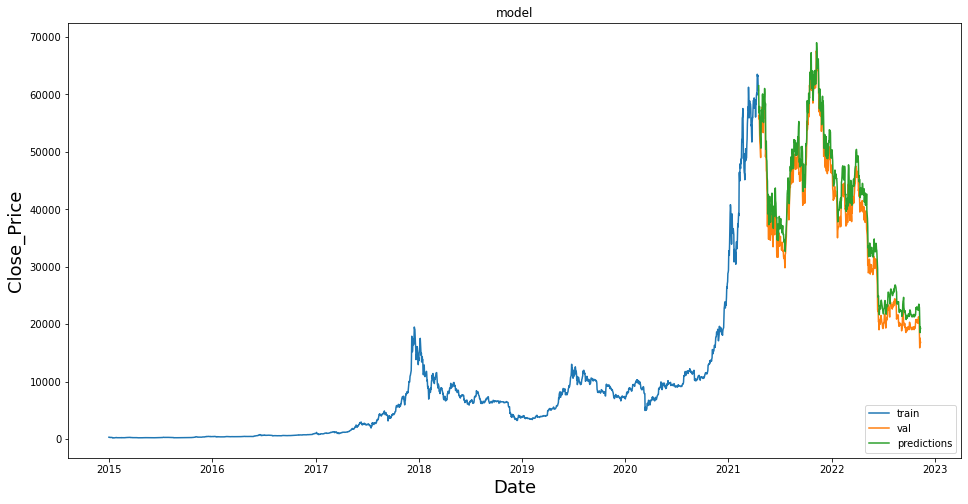

In [35]:
train = df[:train_size]
val = df[train_size:]
val['predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close_Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(val[['Close','predictions']],)
plt.legend(['train', 'val', 'predictions'], loc = 'lower right')
plt.show()